In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn

In [2]:
from tqdm import tqdm
from tqdm import trange

In [3]:

IMAGE_SIZE = 16


composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [4]:
#If you dont have data downloaded in /data dir please set download= True

train_data = dsets.MNIST(root = './data',train = True,download = False,transform = composed)
test_data = dsets.MNIST(root='./data',train = False,download = False,transform = composed)

In [5]:
len(test_data)

10000

In [6]:
train_data_loader = DataLoader(dataset = train_data,batch_size = 1000,shuffle=True)
test_data_loader = DataLoader(dataset = test_data,batch_size = 5000,shuffle=True)

In [7]:
class CNN_batch(nn.Module):
    def __init__(self,filter1=16,filter2=32,number_of_classes=10):
        super(CNN_batch,self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=filter1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        self.conv1_bn = nn.BatchNorm2d(filter1)
        
        self.cnn2 = nn.Conv2d(in_channels=filter1, out_channels=filter2, kernel_size=5, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.conv2_bn = nn.BatchNorm2d(filter2)
        self.fc1 = nn.Linear(filter2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
        
    def forward(self,x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [8]:


class CNN(nn.Module):
    
    # Contructor
    def __init__(self, filter1=16, filter2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=filter1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=filter1, out_channels=filter2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(filter2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [9]:
print(1)

1


In [10]:
def train(lr,epochs,model,train_loader,validation_loader,optimizer):
    #global variable 
    N_test=len(test_data)
    N_train = len(train_data)
    accuracy_list=[]
    loss_list=[]
    
    for i in range(epochs):
        loop = tqdm(train_loader)
        for bid,(x,y) in enumerate(loop):
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)
            correct = 0
            _,yhat = torch.max(z,1)
            correct += (yhat == y).sum().item()
            test_ac = correct / len(x)
            loop.set_description(f'Epoch : [{i}/{epochs}]')
            loop.set_postfix(loss = loss.item(),test_accuracy = test_ac)
            
            
        correct = 0
        for x_test, y_test in validation_loader:
            
            model.eval()
            z= model(x_test)
            _,yhat = torch.max(z,1)
            correct += (yhat == y_test).sum().item()
            
        accuracy = correct / N_test
        
        accuracy_list.append(accuracy)

    return accuracy_list, loss_list

In [11]:
len(test_data_loader)

2

In [12]:
## CNN with batch normalization

model_batch=CNN_batch(filter1=16, filter2=32)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)
accuracy_list_batch, loss_list_batch=train(model=model_batch,epochs=10,train_loader=train_data_loader,validation_loader=test_data_loader,optimizer=optimizer,lr = learning_rate)

Epoch : [9/10]: 100%|██████████| 60/60 [00:06<00:00,  9.09it/s, loss=0.0636, test_accuracy=0.994]


In [13]:
## CNN without batch
model = CNN(filter1=16, filter2=32)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
accuracy_list_normal, loss_list_normal=train(model=model,epochs=10,train_loader=train_data_loader,validation_loader=test_data_loader,optimizer=optimizer,lr = learning_rate)

Epoch : [9/10]: 100%|██████████| 60/60 [00:05<00:00, 10.84it/s, loss=0.125, test_accuracy=0.955] 


<h2 id="Result">Analyze Results</h2> 

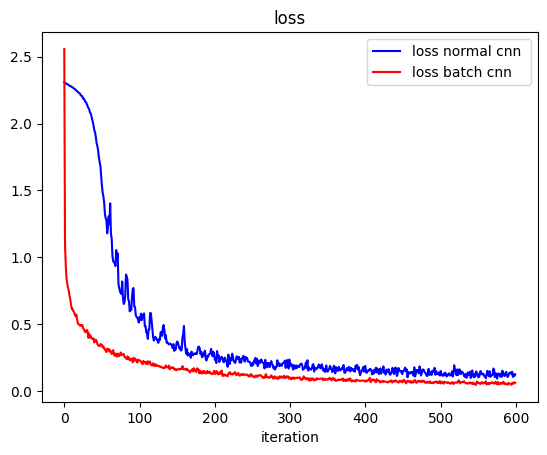

In [14]:
# Plot the loss and accuracy

plt.plot(loss_list_normal, 'b',label='loss normal cnn ')
plt.plot(loss_list_batch,'r',label='loss batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()

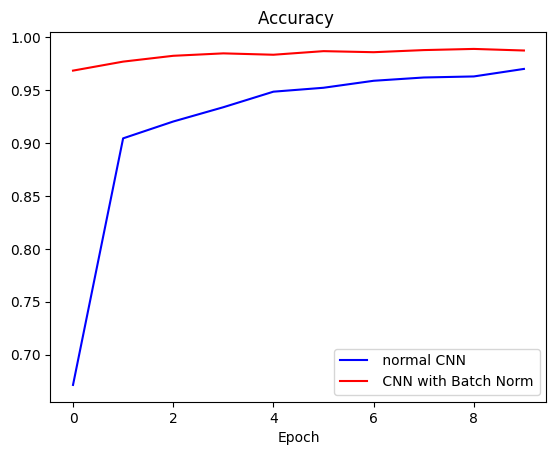

In [15]:
plt.plot(accuracy_list_normal, 'b',label=' normal CNN')
plt.plot(accuracy_list_batch,'r',label=' CNN with Batch Norm')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()